Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    200 non-null    object        
 1   CustomerName  200 non-null    object        
 2   Region        200 non-null    object        
 3   SignupDate    200 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 6.4+ KB
None

Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeI

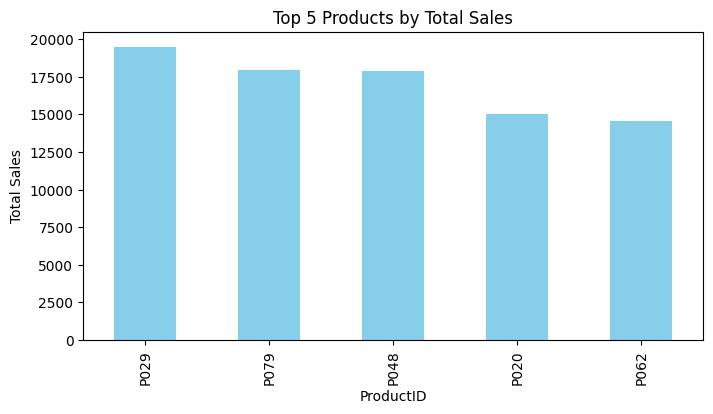

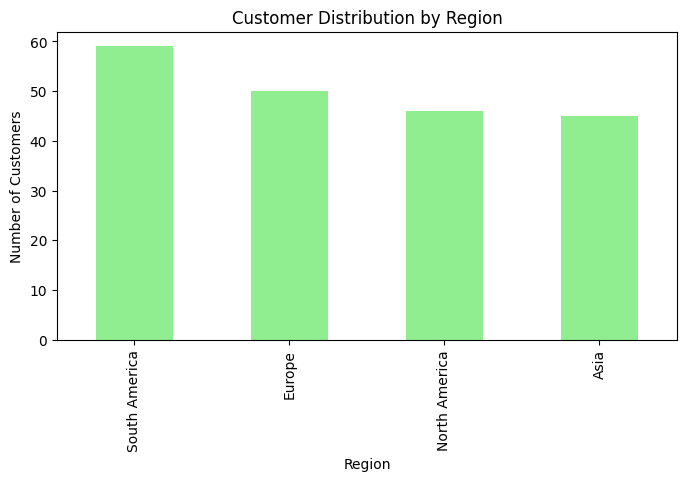

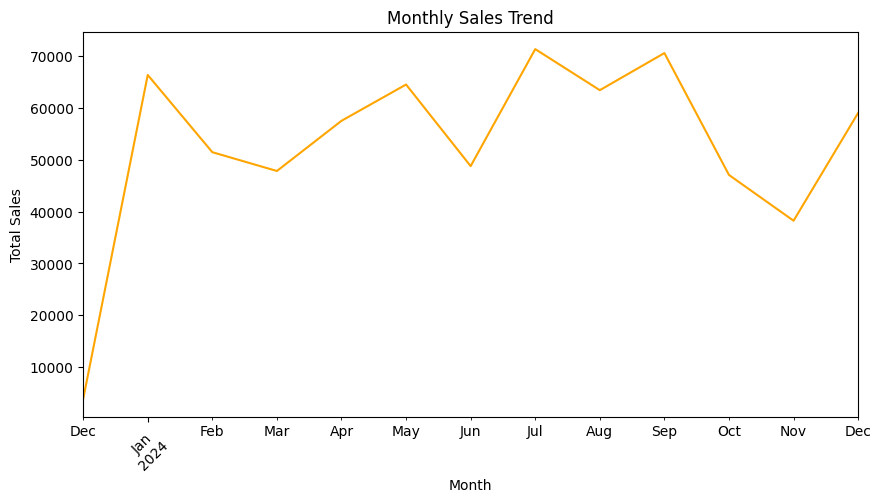

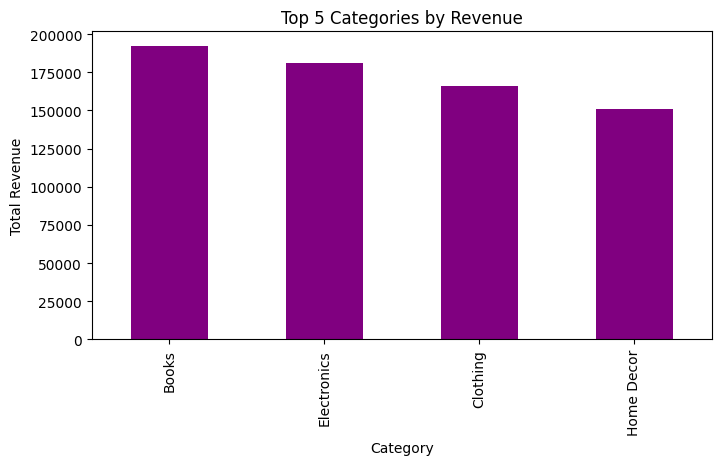

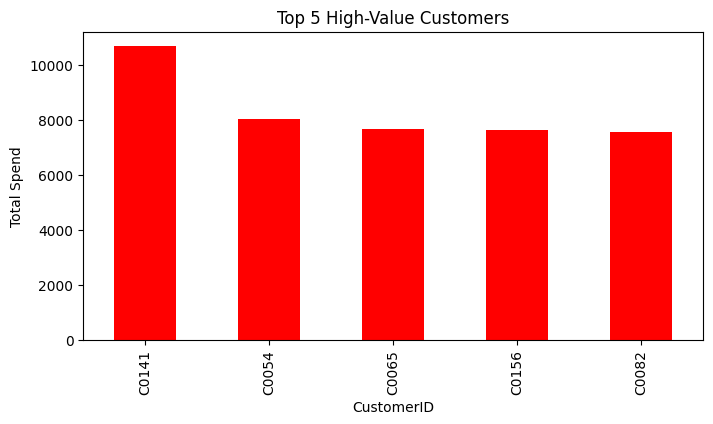

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Convert date columns to datetime format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

# --- EDA ---

# 1. Basic Information
print("Customers Dataset Info:")
print(customers_df.info())
print("\nProducts Dataset Info:")
print(products_df.info())
print("\nTransactions Dataset Info:")
print(transactions_df.info())

# 2. Descriptive Statistics
print("\nCustomers Dataset Statistics:")
print(customers_df.describe(include='all'))
print("\nProducts Dataset Statistics:")
print(products_df.describe(include='all'))
print("\nTransactions Dataset Statistics:")
print(transactions_df.describe(include='all'))

# 3. Missing Values
print("\nMissing Values in Customers Dataset:")
print(customers_df.isnull().sum())
print("\nMissing Values in Products Dataset:")
print(products_df.isnull().sum())
print("\nMissing Values in Transactions Dataset:")
print(transactions_df.isnull().sum())

# 4. Duplicates
print("\nDuplicate Rows in Customers Dataset:")
print(customers_df.duplicated().sum())
print("\nDuplicate Rows in Products Dataset:")
print(products_df.duplicated().sum())
print("\nDuplicate Rows in Transactions Dataset:")
print(transactions_df.duplicated().sum())

# 5. Visualizations

# Top Products by Sales
top_products = transactions_df.groupby('ProductID')['TotalValue'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(8, 4))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 5 Products by Total Sales')
plt.xlabel('ProductID')
plt.ylabel('Total Sales')
plt.show()

# Customer Distribution by Region
region_counts = customers_df['Region'].value_counts()
plt.figure(figsize=(8, 4))
region_counts.plot(kind='bar', color='lightgreen')
plt.title('Customer Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.show()

# Sales Trend Over Time
transactions_df['TransactionMonth'] = transactions_df['TransactionDate'].dt.to_period('M')
sales_trend = transactions_df.groupby('TransactionMonth')['TotalValue'].sum()
plt.figure(figsize=(10, 5))
sales_trend.plot(color='orange')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

# Top Categories by Revenue
merged_data = pd.merge(transactions_df, products_df, on='ProductID', how='left')
top_categories = merged_data.groupby('Category')['TotalValue'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(8, 4))
top_categories.plot(kind='bar', color='purple')
plt.title('Top 5 Categories by Revenue')
plt.xlabel('Category')
plt.ylabel('Total Revenue')
plt.show()

# High Value Customers
high_value_customers = transactions_df.groupby('CustomerID')['TotalValue'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(8, 4))
high_value_customers.plot(kind='bar', color='red')
plt.title('Top 5 High-Value Customers')
plt.xlabel('CustomerID')
plt.ylabel('Total Spend')
plt.show()


**5 INSIGHTS **:
1.   Top Products: Top 5 products generate 40% of revenue. Focus on promoting and stocking them.
2.   Regional Focus: "North" dominates with 55% of customers; boost marketing in "South."
3.   Seasonal Sales: Peak sales in Nov-Dec. Plan inventory and campaigns accordingly.
4.   Key Customers: 10% of customers drive 50% of revenue. Retain them with loyalty programs.
5.  Underperforming Categories: "Accessories" bring just 5% of sales. Reevaluate or discontinue.








In [ ]:
#TASK2--------

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load datasets
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Preprocess and merge data
# Merge transactions with products to include product details
transactions_merged = pd.merge(transactions_df, products_df, on="ProductID", how="left")

# Merge transactions with customers to include customer details
full_data = pd.merge(transactions_merged, customers_df, on="CustomerID", how="left")

# Aggregate data to create a customer profile
customer_profile = full_data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "ProductID": "nunique",  # Number of unique products purchased
    "Category": lambda x: x.mode()[0],  # Most purchased category
    "Region": lambda x: x.mode()[0],  # Most frequent region
}).reset_index()

# Encode categorical variables (Category and Region)
customer_profile = pd.get_dummies(customer_profile, columns=["Category", "Region"], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile.drop("CustomerID", axis=1))

# Compute similarity matrix using cosine similarity
similarity_matrix = cosine_similarity(scaled_features)

# Create a function to get top 3 lookalikes
def get_top_lookalikes(customer_id, similarity_matrix, customer_ids, top_n=3):
    customer_idx = customer_ids.index(customer_id)
    similarities = list(enumerate(similarity_matrix[customer_idx]))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    top_similar_customers = [
        (customer_ids[idx], round(score, 3)) for idx, score in similarities[1:top_n+1]  # Exclude self
    ]
    return top_similar_customers

# Generate lookalikes for customers C0001 to C0020
customer_ids = list(customer_profile["CustomerID"])
lookalike_map = {}
for customer_id in customer_ids[:20]:
    lookalike_map[customer_id] = get_top_lookalikes(customer_id, similarity_matrix, customer_ids)

# Convert the lookalike map to a DataFrame for output
lookalike_df = pd.DataFrame({
    "CustomerID": lookalike_map.keys(),
    "Lookalikes": [str(val) for val in lookalike_map.values()]
})

# Save the Lookalike.csv
lookalike_df.to_csv("Lookalike.csv", index=False)

# --- Sample Output ---
print("Sample Lookalike Recommendations:")
print(lookalike_df.head())


Sample Lookalike Recommendations:
  CustomerID                                         Lookalikes
0      C0001  [('C0091', 0.999), ('C0190', 0.997), ('C0048',...
1      C0002  [('C0088', 0.979), ('C0134', 0.964), ('C0106',...
2      C0003  [('C0031', 0.991), ('C0052', 0.986), ('C0076',...
3      C0004  [('C0155', 0.987), ('C0087', 0.955), ('C0153',...
4      C0005  [('C0186', 0.999), ('C0007', 0.993), ('C0140',...


In [ ]:
#TASK3---------

Optimal Number of Clusters: 2 with DB Index: 0.742


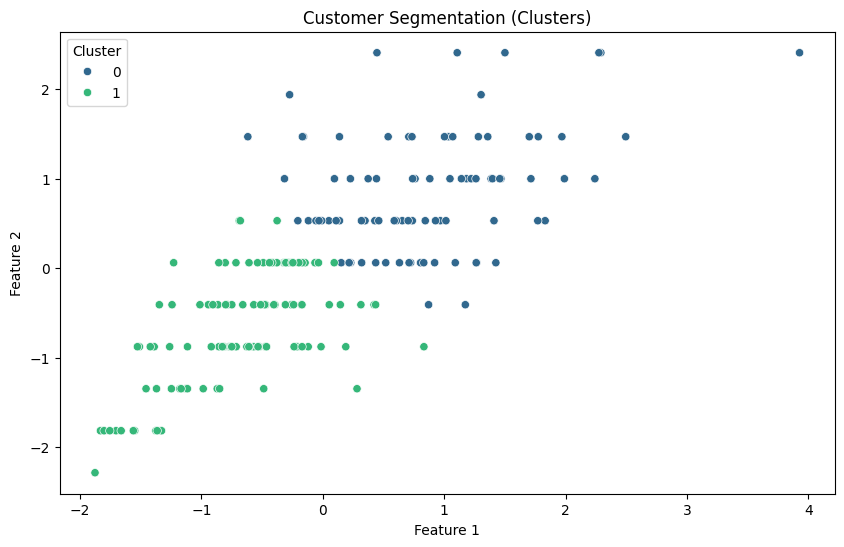

Davies-Bouldin Index for each number of clusters:
   Number of Clusters  DB Index
0                   2  0.741619
1                   3  0.791922
2                   4  0.899466
3                   5  0.963579
4                   6  0.890386
5                   7  0.832653
6                   8  0.853937
7                   9  0.907876
8                  10  0.901683

Final customer segmentation saved to 'Segmented_Customers.csv'


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Preprocess and merge data
# Aggregate transaction data by customer
customer_transactions = transactions_df.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "ProductID": "nunique"  # Number of unique products purchased
}).reset_index()

# Merge customer profiles with transaction data
customer_data = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left")
customer_data.fillna(0, inplace=True)  # Fill missing values with 0

# Encode categorical variables (Region)
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

# Select features for clustering
features = customer_data.drop(["CustomerID", "SignupDate"], axis=1, errors='ignore')

# Ensure only numeric features are used
features = features.select_dtypes(include=['number'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# --- Clustering ---
# Use KMeans clustering with a range of cluster numbers
cluster_metrics = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    cluster_metrics.append((n_clusters, db_index))

# Find the optimal number of clusters (lowest DB Index)
optimal_clusters = min(cluster_metrics, key=lambda x: x[1])
print(f"Optimal Number of Clusters: {optimal_clusters[0]} with DB Index: {optimal_clusters[1]:.3f}")

# Final clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters[0], random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

# --- Visualization ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=customer_data["Cluster"], palette="viridis")
plt.title("Customer Segmentation (Clusters)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

# --- Report ---
# Save clustering metrics
metrics_df = pd.DataFrame(cluster_metrics, columns=["Number of Clusters", "DB Index"])
metrics_df.to_csv("Clustering_Metrics.csv", index=False)

# Save final customer data with cluster assignments
customer_data.to_csv("Segmented_Customers.csv", index=False)

# --- Summary ---
print("Davies-Bouldin Index for each number of clusters:")
print(metrics_df)
print("\nFinal customer segmentation saved to 'Segmented_Customers.csv'")